# Projet réseaux de neurones

## OCR

In [46]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFont, ImageDraw
import numpy as np

### 1. Chargement des données

In [47]:
# Étape 0 : Charger les données
file_path = "data/12.txt"
with open(file_path, "r") as file:
    lines = file.readlines()

tuples = [(l.split('`')[0], l.split('`')[1].strip()) for l in lines]

# Vérification de l'existence des fichiers
result = [(f"data/{item[0]}", item[1], os.path.exists(f"data/{item[0]}")) for item in tuples]

data = []
for file, label, exists in result:
    if exists:
        data.append((file, label))

In [48]:
dataset = data[0:10000]
len(dataset)

10000

### 2. Découpage du mot en caractères

In [49]:
import cv2
import os
from PIL import Image

def split_text_into_characters(image_path):
    """
    Découpe une image de mot en images de caractères individuels.
    
    Parameters:
        image_path (str): Chemin vers l'image du mot.
    
    Returns:
        list: Liste des images des caractères en format PIL.
    """
    # Charger l'image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Prétraitement : Binarisation adaptative
    thresh = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Suppression du bruit (ouverture morphologique)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    denoised = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Détection des contours
    contours, _ = cv2.findContours(denoised, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrer les petits contours (artefacts)
    contours = [c for c in contours if cv2.contourArea(c) > 20]

    # Trier les contours de gauche à droite
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    characters = []

    # Découpage des caractères
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        char_image = image[y:y + h, x:x + w]  # Découper l'image du caractère
        char_pil = Image.fromarray(char_image)  # Convertir en format PIL
        characters.append(char_pil)

    return characters


def process_dataset(dataset):
    """
    Traite un jeu de données pour découper les images de mots en images de caractères.
    
    Parameters:
        dataset (list): Liste de tuples (chemin_image, mot).
    
    Returns:
        list: Liste de tuples ([images des caractères], [caractères]).
    """
    processed_data = []

    wrong_corr = 0
    caracteres_colles = 0
    caracteres_coupes = 0

    for image_path, word in dataset:
        # Découper l'image en caractères
        character_images = split_text_into_characters(image_path)

        # Associer les images des caractères au mot correspondant
        if len(character_images) == len(word):
            processed_data.append((character_images, list(word)))
        else:
            wrong_corr += 1

            if len(character_images) < len(word):
                caracteres_colles += 1
            
            if len(character_images) > len(word):
                caracteres_coupes += 1

            #print(f"Attention : le nombre de caractères détectés ne correspond pas au mot '{word}'.")
    
    print(f"Bonnes correspondances = {len(processed_data)}")
    print(f"Mauvaises correspondances = {wrong_corr}")
    print(f"Caractères collés = {caracteres_colles}")
    print(f"Caractères coupés = {caracteres_coupes}")
    return processed_data

processed_dataset = process_dataset(dataset)


Bonnes correspondances = 2974
Mauvaises correspondances = 7026
Caractères collés = 3330
Caractères coupés = 3696


In [50]:
import cv2
import pytesseract
from pytesseract import Output
from PIL import Image

def split_text_into_characters_tesseract(image_path):
    """
    Découpe une image de mot en images de caractères individuels en utilisant PyTesseract.
    
    Parameters:
        image_path (str): Chemin vers l'image du mot.
    
    Returns:
        list: Liste des images des caractères en format PIL.
    """
    # Charger l'image
    image = cv2.imread(image_path)

    # Convertir en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Prétraitement (binarisation)
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Utiliser PyTesseract pour détecter les caractères
    boxes = pytesseract.image_to_boxes(binary_image, config="--psm 7")

    characters = []

    # Vérifier si des boîtes ont été détectées
    if boxes:
        # Chaque ligne de `boxes` correspond à un caractère au format : char x1 y1 x2 y2 page
        for box in boxes.splitlines():
            box_data = box.split()  # Diviser les informations de la boîte
            if len(box_data) == 6:  # Vérifier le format attendu
                char, x, y, w, h, _ = box_data
                x, y, w, h = map(int, [x, y, w, h])

                # Note : PyTesseract donne des coordonnées basées sur l'origine en bas à gauche
                y = image.shape[0] - y
                h = image.shape[0] - h

                # Découper l'image du caractère
                char_image = binary_image[h:y, x:w]

                # Convertir en format PIL
                char_pil = Image.fromarray(char_image)
                characters.append(char_pil)

    return characters



def process_dataset_tesseract(dataset):
    """
    Traite un jeu de données pour découper les images de mots en images de caractères avec PyTesseract.
    
    Parameters:
        dataset (list): Liste de tuples (chemin_image, mot).
    
    Returns:
        list: Liste de tuples ([images des caractères], [caractères]).
    """
    processed_data = []

    wrong_corr = 0
    caracteres_colles = 0
    caracteres_coupes = 0

    for image_path, word in dataset:
        # Découper l'image en caractères
        character_images = split_text_into_characters_tesseract(image_path)

        # Associer les images des caractères au mot correspondant
        if len(character_images) == len(word):
            processed_data.append((character_images, list(word)))
        else:
            wrong_corr += 1

            if len(character_images) < len(word):
                caracteres_colles += 1
            
            if len(character_images) > len(word):
                caracteres_coupes += 1

            #print(f"Attention : le nombre de caractères détectés ne correspond pas au mot '{word}'.")
    
    print(f"Bonnes correspondances = {len(processed_data)}")
    print(f"Mauvaises correspondances = {wrong_corr}")
    print(f"Caractères collés = {caracteres_colles}")
    print(f"Caractères coupés = {caracteres_coupes}")
    return processed_data

processed_dataset = process_dataset_tesseract(dataset)


### 3. Reconnaissance des caractères du mot

In [41]:
def prepare_data(processed_dataset, image_size=(28, 28)):
    """
    Prépare les données pour l'entraînement du modèle neuronal.
    
    Parameters:
        processed_dataset (list): Liste de tuples ([images des caractères], [caractères]).
        image_size (tuple): Dimensions des images après redimensionnement (par défaut 28x28).
    
    Returns:
        tuple: (X, y) où X est un tableau numpy des images et y les étiquettes correspondantes.
    """
    X = []
    y = []

    for character_images, word_characters in processed_dataset:
        for img, char in zip(character_images, word_characters):
            # Redimensionner l'image à la taille spécifiée
            img_resized = img.resize(image_size)

            # Convertir en tableau numpy
            img_array = np.array(img_resized)

            # Normaliser les valeurs des pixels (0-255 -> 0-1)
            img_normalized = img_array / 255.0

            X.append(img_normalized)
            y.append(char)

    # Convertir en tableaux numpy
    X = np.array(X)
    X = X.reshape(-1, image_size[0], image_size[1], 1)  # Ajouter la dimension des canaux pour CNN
    y = np.array(y)

    return X, y

# Préparer les données
image_size = (28, 28)  # Taille courante pour les modèles de reconnaissance
X, y = prepare_data(processed_dataset, image_size=image_size)

In [42]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encoder les étiquettes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convertir les caractères en indices numériques
y_one_hot = to_categorical(y_encoded)       # Convertir en one-hot encoding

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_character_recognition_model(input_shape, num_classes):
    """
    Crée un modèle CNN pour la reconnaissance de caractères.
    
    Parameters:
        input_shape (tuple): Dimensions de l'image d'entrée (hauteur, largeur, canaux).
        num_classes (int): Nombre total de classes (caractères uniques).
    
    Returns:
        model: Modèle Keras.
    """
    model = Sequential([
        # Couche de convolution
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        # Deuxième couche de convolution
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Flatten
        Flatten(),

        # Couche dense
        Dense(128, activation='relu'),
        Dropout(0.5),

        # Couche de sortie
        Dense(num_classes, activation='softmax'),
    ])
    return model

# Créer le modèle
input_shape = (image_size[0], image_size[1], 1)  # Format (28, 28, 1)
num_classes = len(label_encoder.classes_)       # Nombre total de caractères uniques
model = create_character_recognition_model(input_shape, num_classes)

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/amandine/newenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
# Diviser les données en ensembles d'entraînement et de validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Entraîner le modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,                # Nombre d'époques
    batch_size=32,            # Taille des lots
    verbose=1                 # Afficher les logs d'entraînement
)

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1249 - loss: 3.5025 - val_accuracy: 0.4466 - val_loss: 2.3196
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4033 - loss: 2.4176 - val_accuracy: 0.5058 - val_loss: 1.9462
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4868 - loss: 2.0579 - val_accuracy: 0.5548 - val_loss: 1.7565
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5122 - loss: 1.8581 - val_accuracy: 0.5680 - val_loss: 1.6950
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5429 - loss: 1.7341 - val_accuracy: 0.5914 - val_loss: 1.6369
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5634 - loss: 1.6669 - val_accuracy: 0.6016 - val_loss: 1.5754
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5745 - loss: 1.5426 - val_accuracy: 0.6221 - val_loss: 1.5612
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6000 - loss: 1.4617 - val_accu

In [45]:
def predict_word(image_path, model, label_encoder, image_size=(28, 28)):
    """
    Prédit un mot à partir d'une image de mot.
    
    Parameters:
        image_path (str): Chemin vers l'image du mot.
        model: Modèle entraîné pour la reconnaissance de caractères.
        label_encoder: Encodeur pour convertir les prédictions en caractères.
        image_size (tuple): Dimensions des images pour le modèle.
    
    Returns:
        str: Mot prédit.
    """
    # Découper l'image en caractères
    character_images = split_text_into_characters_tesseract(image_path)

    predicted_word = ""
    for img in character_images:
        # Prétraiter l'image
        img_resized = img.resize(image_size)
        img_array = np.array(img_resized) / 255.0
        img_array = img_array.reshape(1, image_size[0], image_size[1], 1)

        # Prédire le caractère
        prediction = model.predict(img_array)
        char = label_encoder.inverse_transform([np.argmax(prediction)])[0]

        predicted_word += char

    return predicted_word

# Exemple d'utilisation
predicted_word = predict_word("data/agreement.png", model, label_encoder)
print(f"Mot prédit : {predicted_word}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Mot prédit : agreetett


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Affiche l'accuracy et la perte du modèle au cours de l'entraînement.
    
    Parameters:
        history: Objet History retourné par model.fit().
    """
    # Extraire les données de l'entraînement
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    # Afficher l'accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Afficher la perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Afficher les courbes
plot_training_history(history)

In [ ]:
# Sauvegarder le modèle au format TensorFlow
model.save('character_recognition_model')

# Sauvegarder le modèle au format Keras (.h5)
model.save('character_recognition_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Charger un modèle sauvegardé au format TensorFlow
model = load_model('character_recognition_model')

# Charger un modèle sauvegardé au format Keras (.h5)
model = load_model('character_recognition_model.h5')

In [ ]:
# Évaluer le modèle sur les données de validation
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

-------------------------------------------------------------

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Charger les données MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Prétraitement des données
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

y_train = to_categorical(y_train, 10)  # Conversion en one-hot encoding
y_test = to_categorical(y_test, 10)

# Définir le modèle
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 classes pour 10 chiffres
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(x_train, y_train, epochs=10, batch_size=128,
                    validation_split=0.2)

# Évaluer le modèle
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

# Afficher les courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Sauvegarder le modèle
model.save('ocr_model.h5')
print("Modèle sauvegardé sous le nom 'ocr_model.h5'")


2025-01-20 11:08:09.718206: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-20 11:08:09.740387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737367689.778247   29602 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737367689.788244   29602 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 11:08:09.826845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appro

Epoch 1/10


2025-01-20 11:08:15.005670: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


 47/375 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.3943 - loss: 1.7564

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


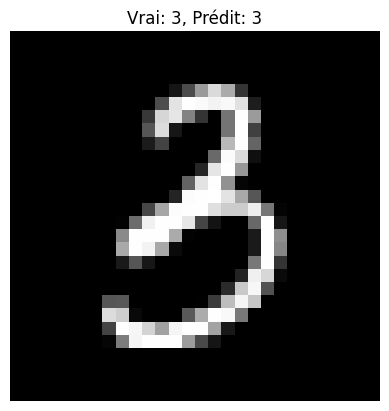

In [4]:
import numpy as np

# Fonction pour afficher une image aléatoire et sa prédiction
def display_random_prediction(model, x_data, y_data):
    # Sélectionner une image aléatoire
    index = np.random.randint(0, len(x_data))
    image = x_data[index]
    true_label = np.argmax(y_data[index])  # Étiquette réelle

    # Faire une prédiction
    prediction = model.predict(image.reshape(1, 28, 28, 1))  # Reshape pour correspondre à l'entrée du modèle
    predicted_label = np.argmax(prediction)

    # Afficher l'image
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Vrai: {true_label}, Prédit: {predicted_label}")
    plt.axis('off')
    plt.show()

# Afficher une prédiction pour une image aléatoire
display_random_prediction(model, x_test, y_test)


In [5]:
import numpy as np

# Fonction pour prédire les caractères d'un mot
def predict_word(model, word_images):
    """
    Prend un modèle entraîné et une liste d'images de caractères, 
    retourne le mot prédit.
    """
    predicted_characters = []
    for char_img in word_images:
        # Redimensionner l'image pour le modèle
        char_img = char_img.reshape(1, 28, 28, 1)  # Ajuster selon les dimensions des caractères
        # Prédiction du caractère
        prediction = model.predict(char_img)
        predicted_char = np.argmax(prediction)  # Classe prédite
        predicted_characters.append(predicted_char)
    return predicted_characters

# Fonction principale pour la détection de mots
def detect_words(model, data):
    """
    Applique le modèle sur une liste de tuples (images, étiquettes) pour détecter les mots.
    """
    results = []
    for word_images, true_labels in data:
        # Prédire les caractères du mot
        predicted_word = predict_word(model, word_images)
        results.append((predicted_word, true_labels))  # Stocker la prédiction et la vérité
    return results

# Exemple d'utilisation
# Jeu de données : liste de tuples (images des caractères, étiquettes)
# Exemple : chaque mot est composé d'une liste de 28x28 images et d'une liste de caractères
example_data = [
    ([np.random.rand(28, 28) for _ in range(5)], [1, 2, 3, 4, 5]),  # Exemple 1
    ([np.random.rand(28, 28) for _ in range(3)], [7, 8, 9])          # Exemple 2
]

# Appliquer la détection de mots
results = detect_words(model, example_data)

# Afficher les résultats
for i, (predicted, true_labels) in enumerate(results):
    print(f"Mot {i+1}:")
    print(f"  Prédit : {predicted}")
    print(f"  Vérité : {true_labels}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mot 1:
  Prédit : [8, 8, 8, 8, 8]
  Vérité : [1, 2, 3, 4, 5]
Mot 2:
  Prédit : [8, 8, 8]
  Vérité : [7, 8, 9]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


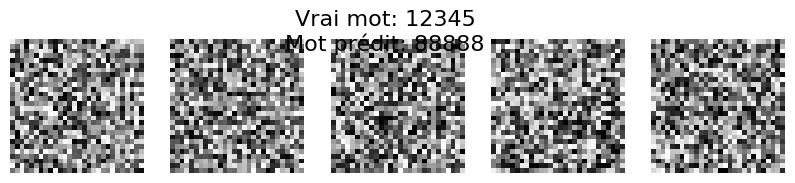

In [6]:
import random
import matplotlib.pyplot as plt

def display_random_word_prediction(model, data, char_mapping):
    """
    Affiche un mot aléatoire et sa prédiction.
    
    Parameters:
        - model : le modèle entraîné
        - data : liste de tuples (images des caractères, étiquettes réelles)
        - char_mapping : dictionnaire pour convertir les indices en caractères lisibles
    """
    # Sélectionner un mot aléatoire
    random_index = random.randint(0, len(data) - 1)
    word_images, true_labels = data[random_index]

    # Prédire chaque caractère
    predicted_labels = predict_word(model, word_images)

    # Convertir les indices en caractères
    true_word = ''.join([char_mapping[label] for label in true_labels])
    predicted_word = ''.join([char_mapping[label] for label in predicted_labels])

    # Afficher les images des caractères
    plt.figure(figsize=(10, 2))
    for i, char_img in enumerate(word_images):
        plt.subplot(1, len(word_images), i + 1)
        plt.imshow(char_img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Vrai mot: {true_word}\nMot prédit: {predicted_word}", fontsize=16)
    plt.show()

# Exemple de dictionnaire de mappage (à adapter à votre cas)
# Si les étiquettes sont des indices [0-9], on peut mapper à des chiffres
char_mapping = {i: str(i) for i in range(10)}  # Par exemple, pour des chiffres

# Afficher un mot aléatoire et sa prédiction
display_random_word_prediction(model, example_data, char_mapping)


------------------------------------------------------

In [ ]:
# Étape 0 : Charger les données
file_path = "data/12.txt"
with open(file_path, "r") as file:
    lines = file.readlines()

tuples = [(l.split('`')[0], l.split('`')[1].strip()) for l in lines]

# Vérification de l'existence des fichiers
result = [(f"data/{item[0]}", item[1], os.path.exists(f"data/{item[0]}")) for item in tuples]

data = []
for file, label, exists in result:
    if exists:
        data.append((file, label))

data = data[0:10000]
len(data)

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

class WordDataset(Sequence):
    def __init__(self, data, batch_size, input_size=(128, 32)):
        """
        data: liste de tuples (chemin_image, texte)
        batch_size: taille du batch
        input_size: dimensions de l'image redimensionnée
        """
        self.data = data
        self.batch_size = batch_size
        self.input_size = input_size

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, labels = [], []
        for image_path, text in batch_data:
            # Charger l'image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, self.input_size) / 255.0  # Normaliser
            images.append(image)

            # Générer les annotations (boîtes englobantes)
            label = self.generate_annotations(image, text)
            labels.append(label)

        return np.expand_dims(np.array(images), -1), np.array(labels)

    def generate_annotations(self, image, text):
        """
        Génère des annotations sous forme de boîtes englobantes pour chaque caractère.
        Exemple : [[x_min, y_min, x_max, y_max], ...]
        """
        height, width = image.shape
        char_width = width // len(text)
        boxes = []
        for i, char in enumerate(text):
            x_min = i * char_width
            x_max = (i + 1) * char_width
            y_min = 0
            y_max = height
            boxes.append([x_min / width, y_min / height, x_max / width, y_max / height])
        return np.array(boxes)


In [ ]:
from tensorflow.keras import layers, models

def build_model(input_size=(128, 32, 1), num_boxes=10):
    """
    input_size: dimensions de l'image d'entrée
    num_boxes: nombre maximal de caractères dans une image
    """
    inputs = layers.Input(shape=input_size)

    # Feature extraction
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layer (4 coordonnées par boîte)
    outputs = layers.Dense(num_boxes * 4, activation='sigmoid')(x)
    outputs = layers.Reshape((num_boxes, 4))(outputs)

    return models.Model(inputs, outputs)

model = build_model()
model.summary()


In [ ]:
# Compiler le modèle
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Charger vos données
# Exemple : data = [("chemin/vers/image1.png", "MOT"), ...]
train_data = WordDataset(data=train_data, batch_size=32)
val_data = WordDataset(data=val_data, batch_size=32)

# Entraîner le modèle
model.fit(train_data, validation_data=val_data, epochs=20)


In [ ]:
def visualize_predictions(model, image_path, text):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, (128, 32)) / 255.0
    image_input = np.expand_dims(image_resized, axis=(0, -1))

    # Prédictions
    predicted_boxes = model.predict(image_input)[0]
    
    # Afficher l'image et les boîtes prédictes
    height, width = image.shape
    for box in predicted_boxes:
        x_min, y_min, x_max, y_max = box
        x_min, x_max = int(x_min * width), int(x_max * width)
        y_min, y_max = int(y_min * height), int(y_max * height)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 1)

    plt.imshow(image, cmap='gray')
    plt.show()

# Exemple
visualize_predictions(model, "chemin/vers/image.png", "MOT")
